# Machinery Auction Price Prediction

Given approximately 400,000 observations of the auction pricing, we are trying to predict new auction prices.

We will use a few different regressors, go through a thorough analysis on the training set and step by step trying to come out with a proper data pipeline.

1. load the data
2. explore each feature
    - how to handle nulls
    - how to check for outliers
3. engineer new features
4. choose the right model through experimentation
5. grid search and perform cross validation for the best parameters

Jan 11, 2017

John Zhu

In [26]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import scipy.stats as scs
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

from sklearn.tree import DecisionTreeRegressor
# from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import xgboost as xgb

## Part 1, Load the Data

In [27]:
# Data-specific area

df = pd.read_csv('data/train.csv', low_memory=False, parse_dates=[9], infer_datetime_format=True)
df['SalesID'] = df['SalesID'].astype(int)
df['ProductGroup'] = df['ProductGroup'].astype('category')
df['fiModelDesc'] = df['fiModelDesc'].astype('category')

df['sale_year'] = df['saledate'].dt.year
df['sale_month'] = df['saledate'].dt.month
df['sale_day'] = df['saledate'].dt.day
df['sale_day_of_week'] = df['saledate'].dt.dayofweek

df['age'] = df['sale_year'] - df['YearMade']

df['saledate'] = df['saledate'].astype(int)
df['saledate'] = df['saledate'] / 1E11

y_colname = 'SalePrice'

df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,sale_year,sale_month,sale_day,sale_day_of_week,age
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,11636352.0,...,NaN,NaN,NaN,Standard,Conventional,2006,11,16,3,2
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,10802592.0,...,NaN,NaN,NaN,Standard,Conventional,2004,3,26,4,8
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,10777536.0,...,NaN,NaN,NaN,NaN,NaN,2004,2,26,3,3
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,13057632.0,...,NaN,NaN,NaN,NaN,NaN,2011,5,19,3,10
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,12483072.0,...,NaN,NaN,NaN,NaN,NaN,2009,7,23,3,2


## Part 2, Explore Each Feature

In [28]:
# what are the columns with least amount of nulls?
length = len(df)
null_df = pd.DataFrame(sorted([[df[column].isnull().sum()/length,column] for column in df.columns]), columns=['pct_nulls', 'column'])
null_df

,pct_nulls,column
0,0.000000,MachineID
1,0.000000,ModelID
2,0.000000,ProductGroup
3,0.000000,ProductGroupDesc
4,0.000000,SalePrice
5,0.000000,SalesID
6,0.000000,YearMade
7,0.000000,age
8,0.000000,datasource
9,0.000000,fiBaseModel


In [29]:
# Removing columns that have nulls beyond %threshold

pct_threshold = 0.0
df = df.loc[:,list(null_df[null_df['pct_nulls'] <= pct_threshold]['column'].values)]
df

,MachineID,ModelID,ProductGroup,ProductGroupDesc,SalePrice,SalesID,YearMade,age,datasource,fiBaseModel,fiModelDesc,fiProductClassDesc,sale_day,sale_day_of_week,sale_month,sale_year,saledate,state
0,999089,3157,WL,Wheel Loader,66000,1139246,2004,2,121,521,521D,Wheel Loader - 110.0 to 120.0 Horsepower,16,3,11,2006,11636352.0,Alabama
1,117657,77,WL,Wheel Loader,57000,1139248,1996,8,121,950,950FII,Wheel Loader - 150.0 to 175.0 Horsepower,26,4,3,2004,10802592.0,North Carolina
2,434808,7009,SSL,Skid Steer Loaders,10000,1139249,2001,3,121,226,226,Skid Steer Loader - 1351.0 to 1601.0 Lb Operat...,26,3,2,2004,10777536.0,New York
3,1026470,332,TEX,Track Excavators,38500,1139251,2001,10,121,PC120,PC120-6E,"Hydraulic Excavator, Track - 12.0 to 14.0 Metr...",19,3,5,2011,13057632.0,Texas
4,1057373,17311,SSL,Skid Steer Loaders,11000,1139253,2007,2,121,S175,S175,Skid Steer Loader - 1601.0 to 1751.0 Lb Operat...,23,3,7,2009,12483072.0,New York
5,1001274,4605,BL,Backhoe Loaders,26500,1139255,2004,4,121,310,310G,Backhoe Loader - 14.0 to 15.0 Ft Standard Digg...,18,3,12,2008,12295584.0,Arizona
6,772701,1937,TEX,Track Excavators,21000,1139256,1993,11,121,790,790ELC,"Hydraulic Excavator, Track - 21.0 to 24.0 Metr...",26,3,8,2004,10934784.0,Florida
7,902002,3539,BL,Backhoe Loaders,27000,1139261,2001,4,121,416,416D,Backhoe Loader - 14.0 to 15.0 Ft Standard Digg...,17,3,11,2005,11321856.0,Illinois
8,1036251,36003,TEX,Track Excavators,21500,1139272,2008,1,121,430,430HAG,"Hydraulic Excavator, Track - 3.0 to 4.0 Metric...",27,3,8,2009,12513312.0,Texas
9,1016474,3883,WL,Wheel Loader,65000,1139275,1000,1007,121,988,988B,Wheel Loader - 350.0 to 500.0 Horsepower,9,3,8,2007,11866176.0,Florida


In [30]:
# count the number of unique items in each column
length = len(df)
unique_df = pd.DataFrame(sorted([[df[column].nunique(), df[column].nunique()/length,column] for column in df.columns]), columns=['num_unique','pct_unique', 'column'])
unique_df

,num_unique,pct_unique,column
0,5,0.000012,datasource
1,6,0.000015,ProductGroup
2,6,0.000015,ProductGroupDesc
3,7,0.000017,sale_day_of_week
4,12,0.000030,sale_month
5,23,0.000057,sale_year
6,31,0.000077,sale_day
7,53,0.000132,state
8,72,0.000179,YearMade
9,74,0.000184,fiProductClassDesc


In [31]:
#the data type for each column
for column in df.columns:
    print(df[column].dtype,column)

int64 MachineID
int64 ModelID
category ProductGroup
object ProductGroupDesc
int64 SalePrice
int64 SalesID
int64 YearMade
int64 age
int64 datasource
object fiBaseModel
category fiModelDesc
object fiProductClassDesc
int64 sale_day
int64 sale_day_of_week
int64 sale_month
int64 sale_year
float64 saledate
object state


In [32]:
# which columns are currently numeric?
numeric_idx = [True if df[column].dtype in ['int32','int64','float32','float64'] else False for column in df.columns]

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 18 columns):
MachineID             401125 non-null int64
ModelID               401125 non-null int64
ProductGroup          401125 non-null category
ProductGroupDesc      401125 non-null object
SalePrice             401125 non-null int64
SalesID               401125 non-null int64
YearMade              401125 non-null int64
age                   401125 non-null int64
datasource            401125 non-null int64
fiBaseModel           401125 non-null object
fiModelDesc           401125 non-null category
fiProductClassDesc    401125 non-null object
sale_day              401125 non-null int64
sale_day_of_week      401125 non-null int64
sale_month            401125 non-null int64
sale_year             401125 non-null int64
saledate              401125 non-null float64
state                 401125 non-null object
dtypes: category(2), float64(1), int64(11), object(4)
memory usage: 50.2+ MB


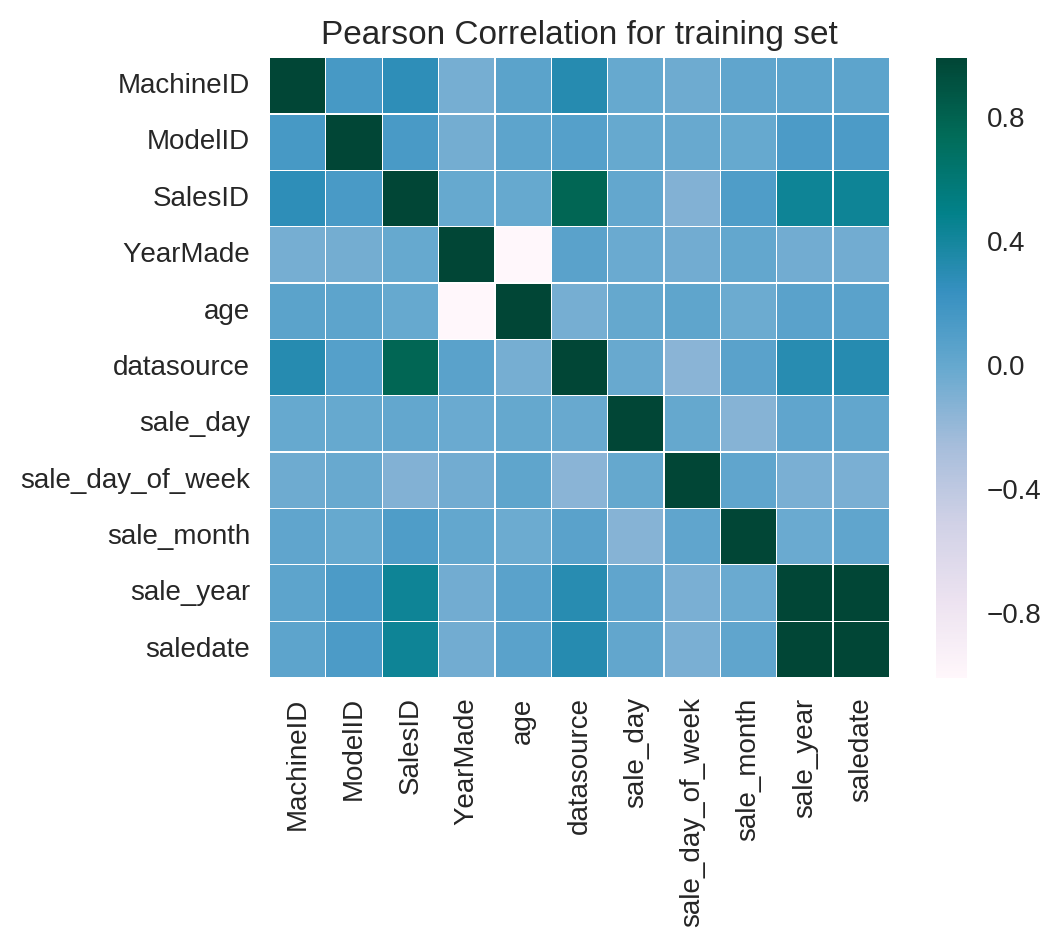

In [34]:
# Subsettign the data
X_df = df.iloc[:,numeric_idx]
y = df[y_colname]
del X_df[y_colname]

X = X_df.values

plt.title('Pearson Correlation for training set')
sns.heatmap(X_df.corr(),
            linewidths=0.1,
            vmax=1.0, 
            square=True, 
            cmap="PuBuGn", 
            linecolor='w', 
            annot=False)

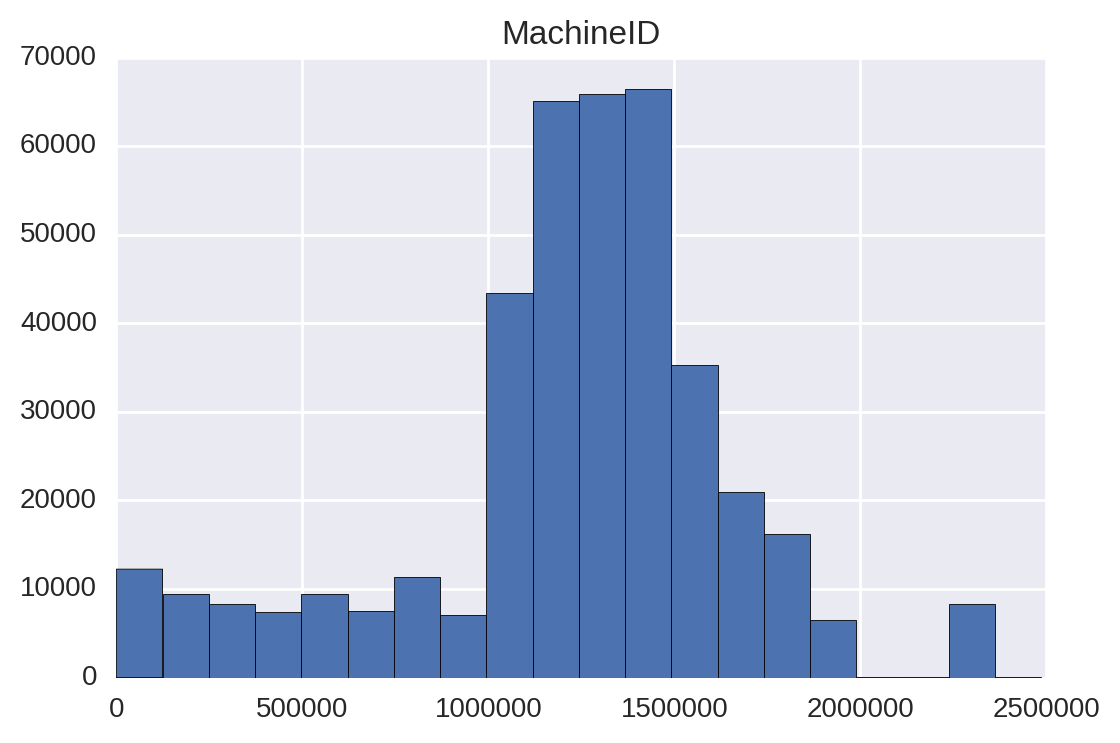

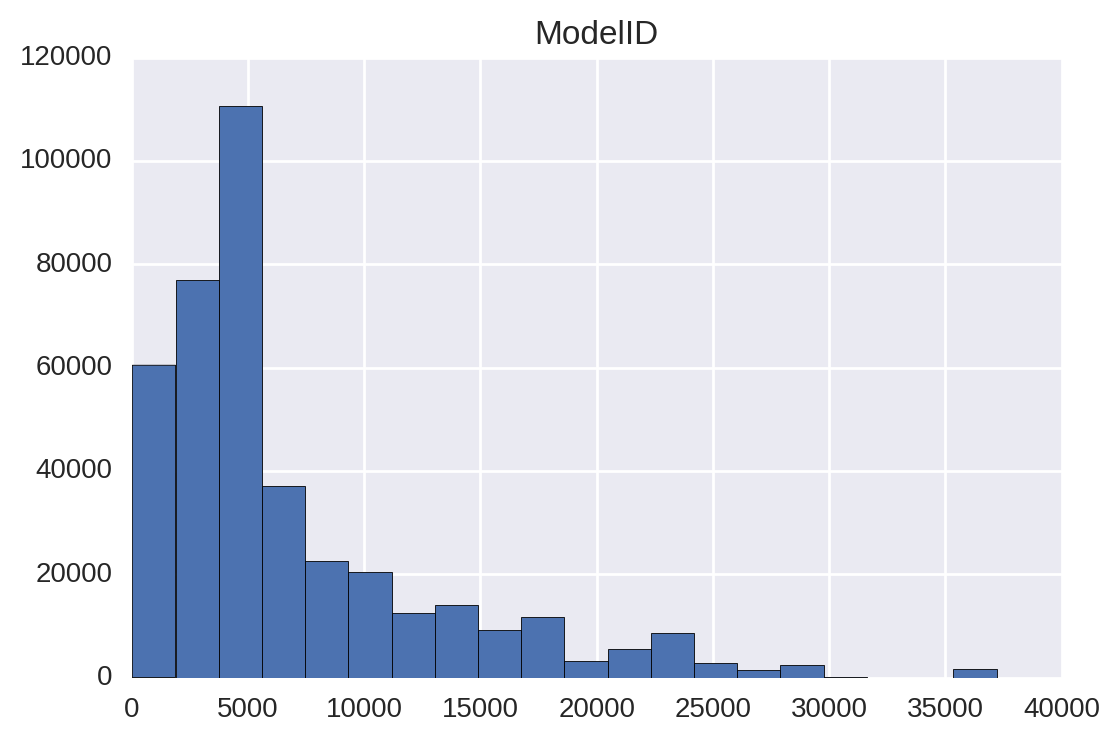

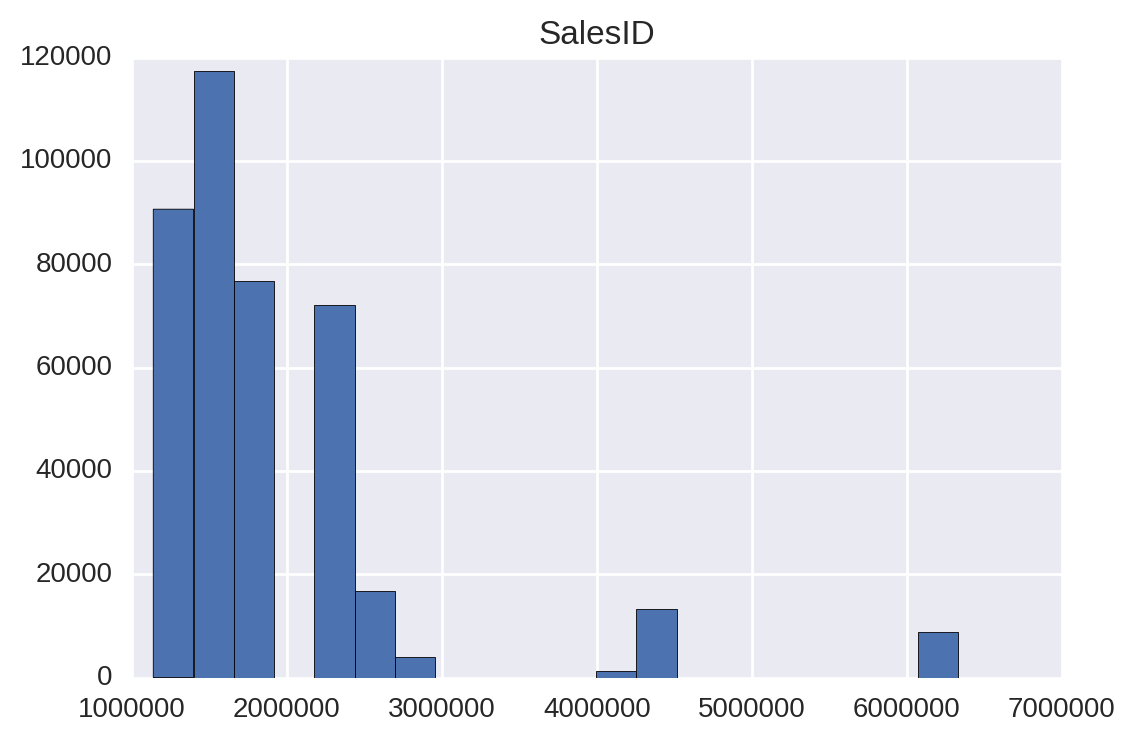

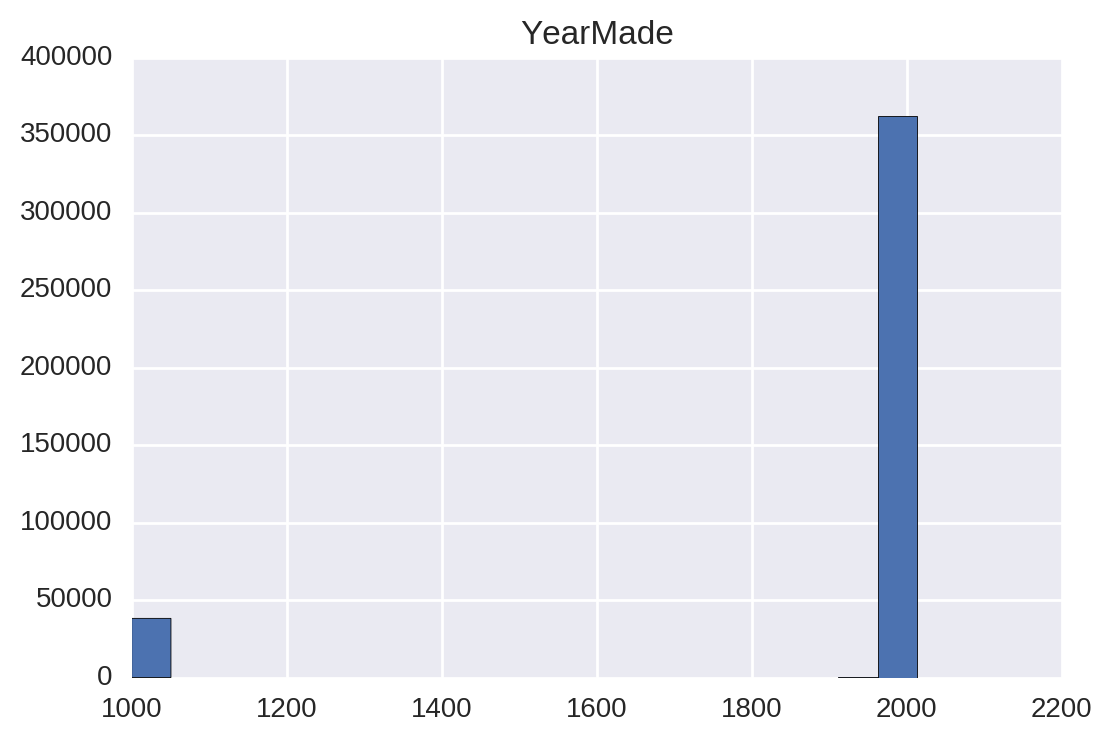

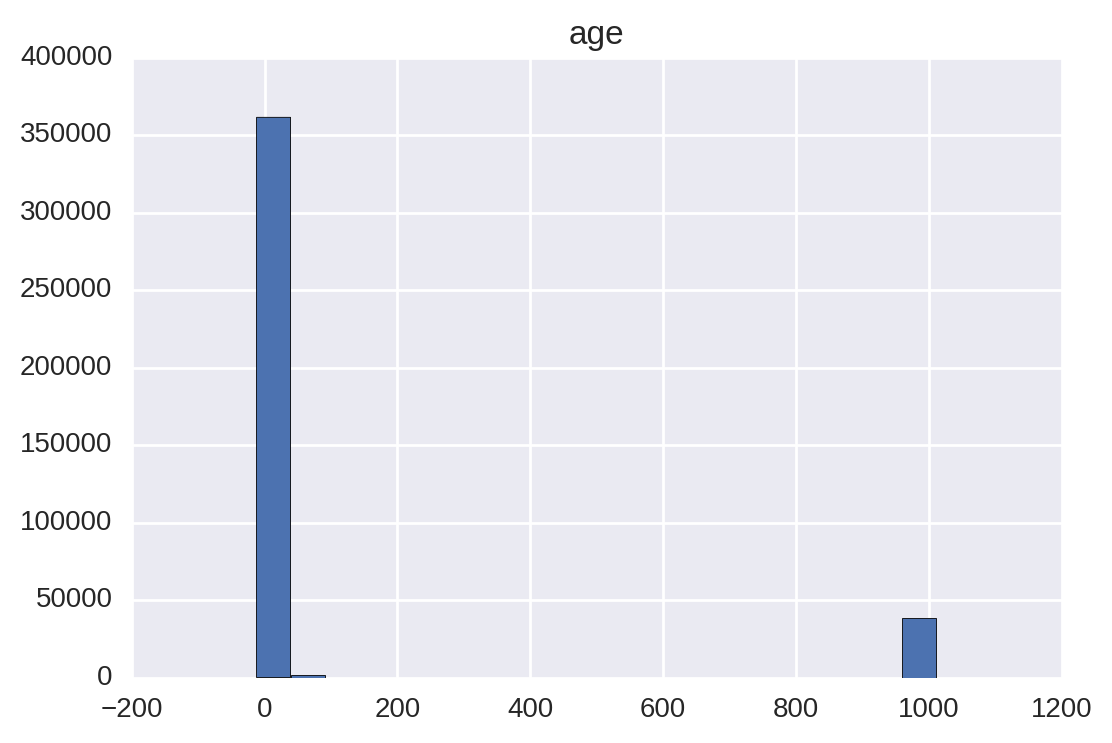

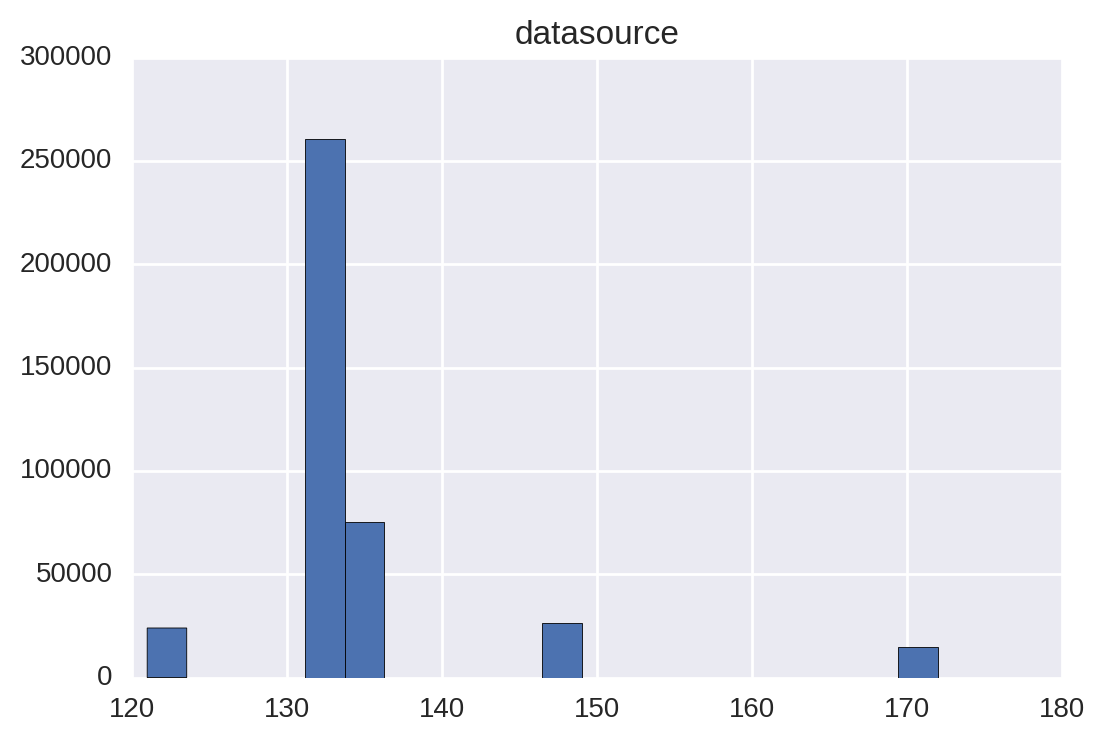

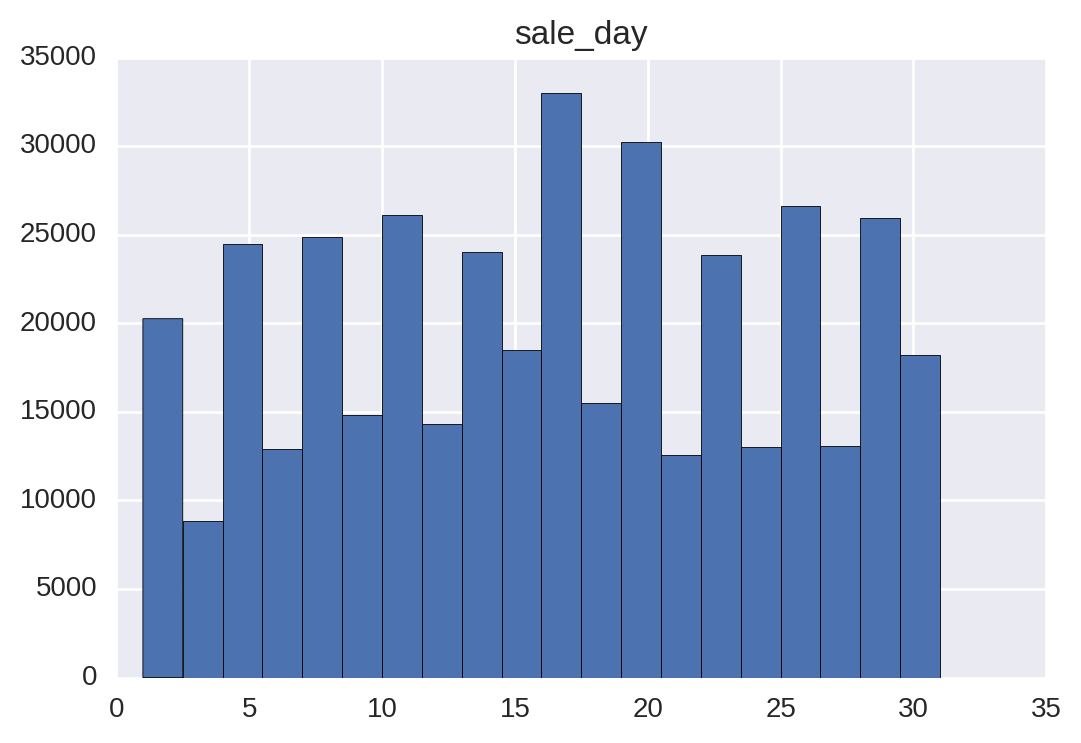

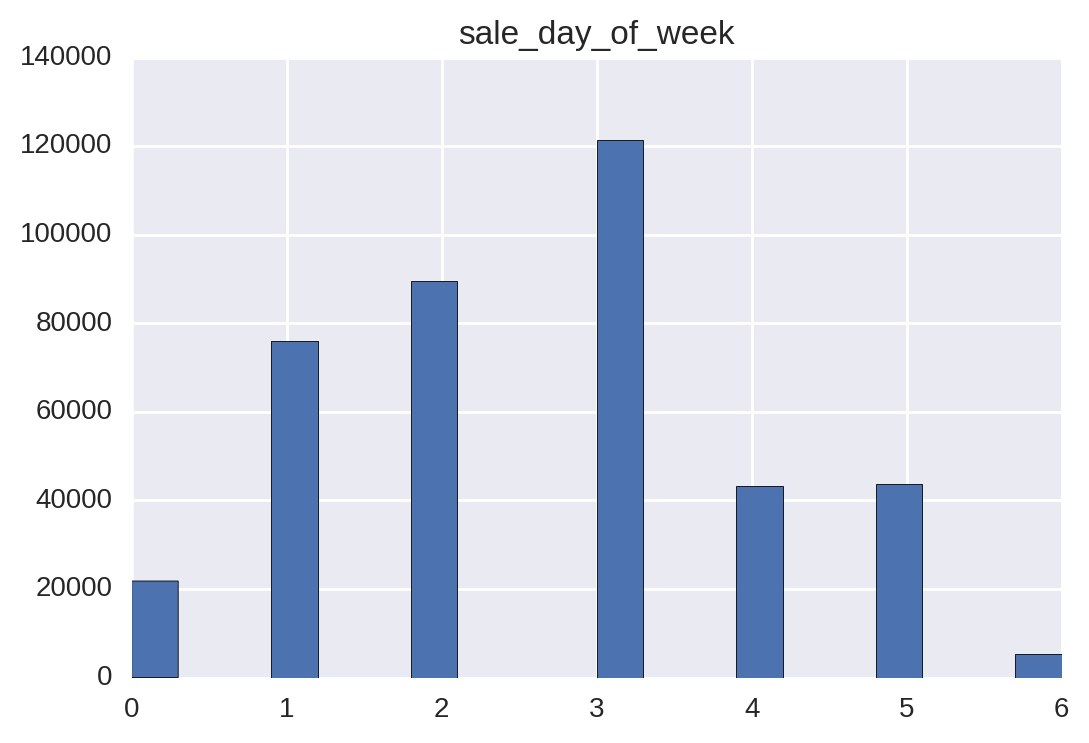

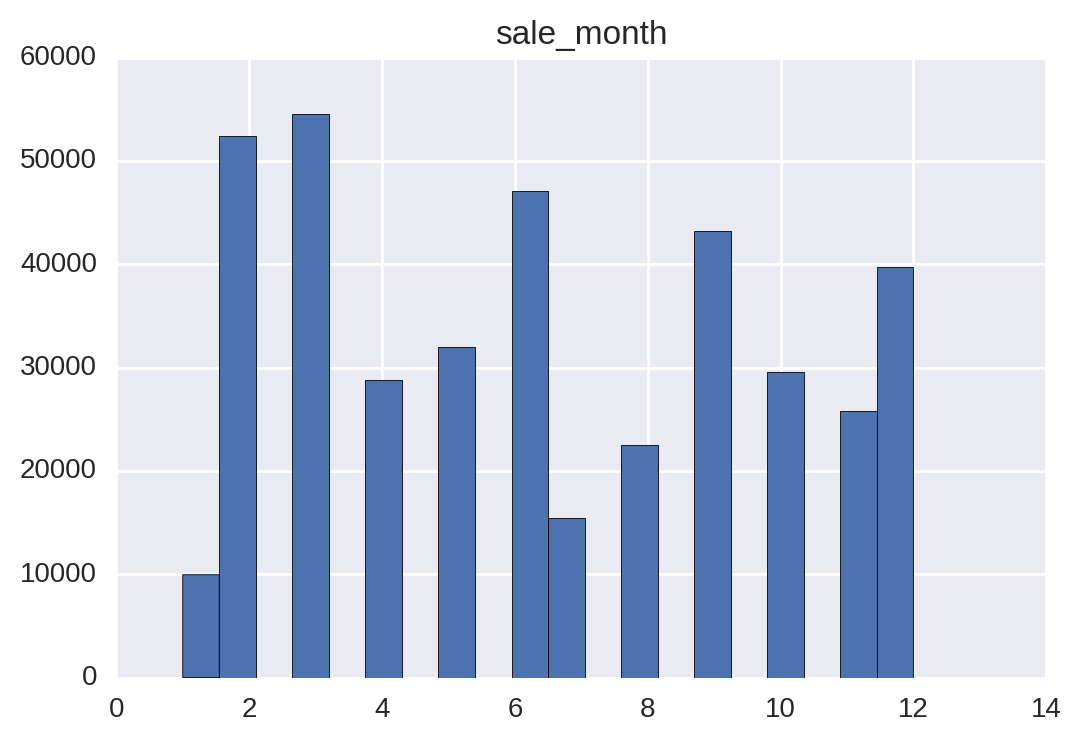

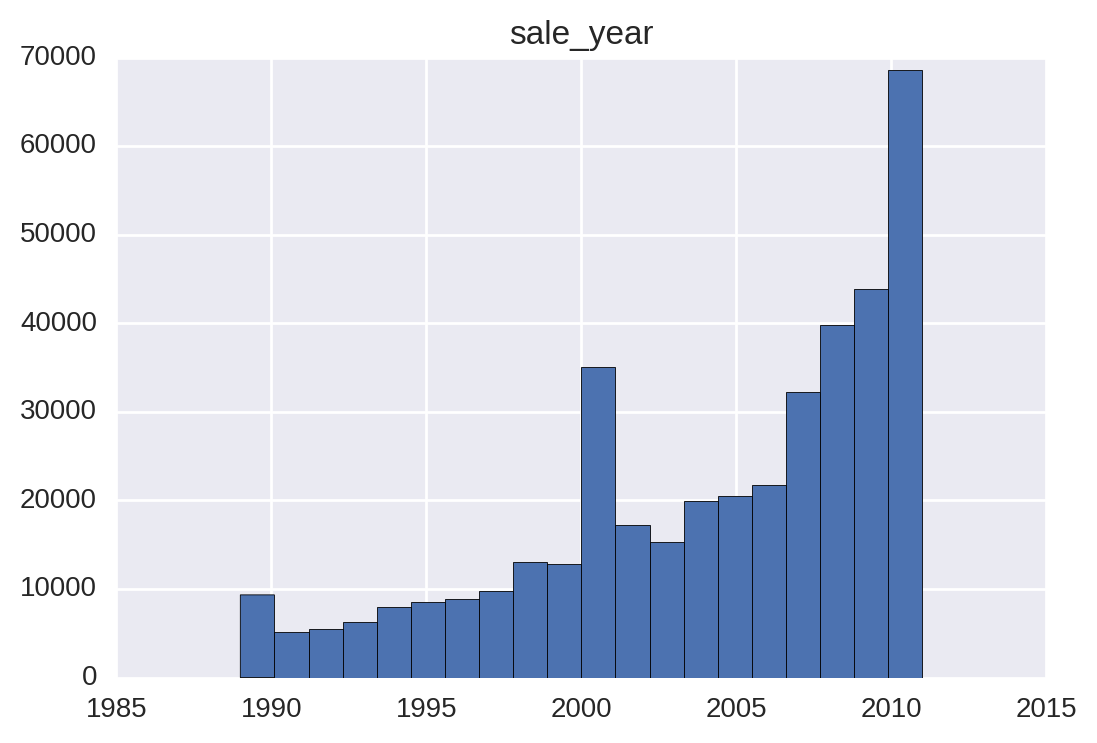

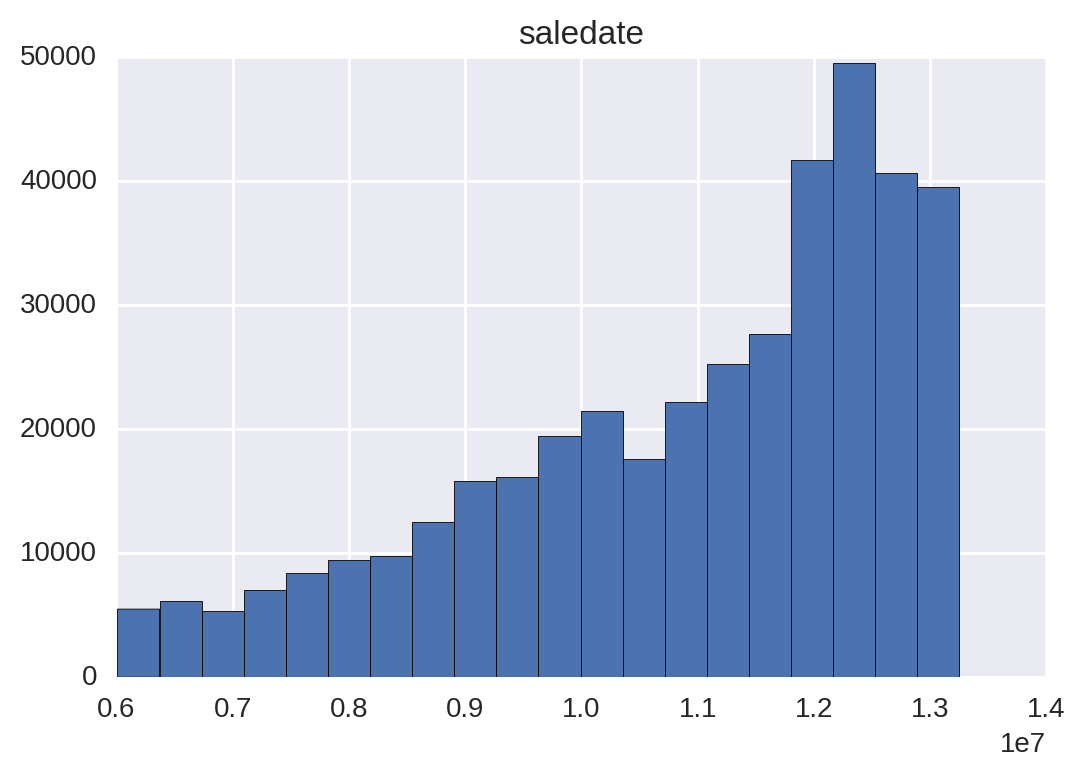

In [35]:
for column in X_df.columns:
    plt.hist(df[column], bins=20)
    #sns.stripplot(x=column, y='SalePrice', data=df, size=1, jitter=True);
    plt.title(column)
    plt.show()
    plt.clf()

In [36]:
X_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 11 columns):
MachineID           401125 non-null int64
ModelID             401125 non-null int64
SalesID             401125 non-null int64
YearMade            401125 non-null int64
age                 401125 non-null int64
datasource          401125 non-null int64
sale_day            401125 non-null int64
sale_day_of_week    401125 non-null int64
sale_month          401125 non-null int64
sale_year           401125 non-null int64
saledate            401125 non-null float64
dtypes: float64(1), int64(10)
memory usage: 33.7 MB


In [ ]:
X_df

## Part 4, Engineer new features


## Part 5, Split into train and test

In [37]:
X = X_df.values
y = y.values

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=1,test_size = 0.20)

## Part 5, Choose the right model through experimentation

In [ ]:
model = xgb.XGBClassifier(max_depth=3, n_estimators=50, learning_rate=0.05, nthread=4)
fit = model.fit(X_train, y_train, early_stopping_rounds=10,verbose=True)
predictions = gbm.predict(X_test)

In [ ]:
model = AdaBoostRegressor(DecisionTreeRegressor(),
                            learning_rate=0.1,
                            loss='linear',
                            n_estimators=100,
                            random_state=1)
fit = model.fit(X_train,y_train)
y_pred = fit.predict(X_test)

In [ ]:
plt.sca

In [ ]:
mse = mean_squared_error(y_test, y_pred)
r_2 = r2_score(y_test, y_pred)
print("MSE:{}, R2:{}".format(mse,r_2))

In [ ]:
plt.figure(figsize=(15,15))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.show()

In [ ]:
import math

#A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

In [ ]:
rmsle(y_test,y_pred)

In [ ]:
df = pd.read_csv('data/test.csv',low_memory=False, parse_dates=[8], infer_datetime_format=True)
df['SalesID'] = df['SalesID'].astype(int)
df['saledate'] = df['saledate'].astype(int)
df['saledate'] = df['saledate'] / 1E11
df['ProductGroup'] = df['ProductGroup'].astype('category')
df['fiModelDesc'] = df['fiModelDesc'].astype('category')

In [ ]:
X_candidates = df.iloc[:,[0,5,8,9,17]] #7 ommited 'machine current hour'
X_candidates
X = X_candidates.values


In [ ]:
y_pred = fit.predict(X[:,:3])

In [ ]:
df = X_candidates.iloc[:,[0]]

In [ ]:
df['SalePrice'] = pd.Series(y_pred)

In [ ]:
df

In [ ]:
plt.scatter(df['ModelID'], df['SalePrice'], alpha=0.005)

In [ ]:
df.to_csv('predictions.csv')

In [ ]:
plt.figure(figsize=(15,15))
sns.stripplot(x="", y="SalePrice", data=df, size=1, jitter=1);

In [ ]:
X_candidates.iloc[:,2]

In [ ]:
plt.scatter(df['datasource'], df['SalePrice'])
plt.show()

In [ ]:
plt.scatter(df[df['YearMade'] > 1950]['YearMade'], df[df['YearMade'] > 1950]['SalePrice'], alpha = 0.005)
plt.show()

In [ ]:
plt.scatter(df['saledate'].astype(int), df['SalePrice'], alpha = 0.005)
plt.show()

In [ ]:
df[df['SalePrice'] == 10000]['ModelID'].hist(bins=1000)
plt.show()

In [ ]:
len(df['ModelID'].unique())

In [ ]:
df['fiBaseModel']

In [ ]:
plt.scatter(df[df['YearMade']>1930]['YearMade'],df[df['YearMade']>1930]['MachineHoursCurrentMeter'], alpha=0.1)


In [ ]:
plt.scatter(df['SalesID'],df['SalePrice'], alpha=0.01)


In [ ]:
X_candidates

In [ ]:
a=[1,4,2,3,5,0]

In [ ]:
pd.stats.moments.